# Imports & Constants

In [363]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import numpy as np
import shutil
import time
import json
from time import sleep
from datetime import datetime
import re



def extract_time_format_from_datetime(formatted_time):
    if("T" in formatted_time):
      formatted_time = formatted_time.split("+")[0]
      formatted_time = formatted_time.replace("T", " ")
      return "%Y-%m-%dT%H:%M:%S"
    return "%Y-%m-%d %H:%M:%S.%f"
def convert_datetime_to_time_since_last_epoch(formatted_time):
    time_format = extract_time_format_from_datetime(formatted_time)
    time_struct = time.strptime(formatted_time, time_format)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()

# Most recent directory
galaxy_watch_folder_dir = "./data/galaxywatch/"+os.listdir("./data/galaxywatch/")[-1] + "/"
exercise_logs_folder_dir = "./data/exerciselogs/"
computer_usage_folder_dir = "./data/computerusage/"
calendar_events_folder_dir = "./data/calendar/2023-10-31"


# No data filter
# data_start_time = 0

# First day of college 
data_end_time = 9e50
data_start_time = 0

# 3 weeks out
# data_start_time = round(convert_datetime_to_time_since_last_epoch("2023-9-15 00:00:00.0"))
# data_end_time = round(convert_datetime_to_time_since_last_epoch("2023-10-11 00:00:00.0"))
# data_end_time, data_start_time

if data_end_time >= 9e20:
  data_end_time = time.time()


# Data Management

In [113]:
# Check to see if there is any new data (from my android phone)
# Define the source and destination directories
src_dir = "/run/user/1000/gvfs/mtp:host=motorola_motorola_one_5G_ace_ZY22DDHW4G/Internal shared storage/Download/Samsung Health"
dest_dir = "./data/galaxywatch"

# Loop through all the directories in the source directory
for dir_name in os.listdir(src_dir):
    # Check if the item is a directory
    if os.path.isdir(os.path.join(src_dir, dir_name)):
        # Check if the directory already exists in the destination directory
        if not os.path.exists(os.path.join(dest_dir, dir_name)):
            # If it doesn't exist, copy it over
            shutil.copytree(os.path.join(src_dir, dir_name), os.path.join(dest_dir, dir_name))

In [2]:
# Clean up the data a but
dest_dir = "./data/galaxywatch/"
for dir_name in os.listdir(dest_dir):
    folder_dir = f"{dest_dir}/{dir_name}/"

    # Do some cleaning on the folder data
    date_time_of_upload = folder_dir.split("_")[-1][:-1]

    # Rename all of the files so that they are easier to deal with
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        if "com.samsung" not in file_name:
            continue
        new_file_name = file_name.replace(".".join(file_name.split(
            ".")[:3]) + ".", "").replace(date_time_of_upload + ".", "")
        os.rename(folder_dir + file_name, folder_dir + new_file_name)

    # Clean csv's so that they dont have that first line with junk
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        file_text = ""
        with open(folder_dir + file_name, "r") as f:
            file_text = f.read()

            if "com.samsung" in (file_text.split("\n")[0]):
                file_text = "\n".join(file_text.split("\n")[1:])
                with open(folder_dir + file_name, "w") as f:
                    f.write(file_text)


# Helper functions

In [2]:
def compute_correlation(df_1, df_2, x_axis, y_axies):
    # Convert the "date" column to a datetime type
    if x_axis == "date":
        df_1[x_axis] = pd.to_datetime(df_1[x_axis])
        df_2[x_axis] = pd.to_datetime(df_2[x_axis])

    # Merge the sleep and computer usage DataFrames on the date column
    if x_axis != "index":
        merged_df = pd.merge(df_1, df_2, on=x_axis)
    else:
        merged_df = pd.merge(df_1, df_2, on="date")

    # Compute the correlation between "last_time_used" and "sleep_amount"
    correlation = merged_df[y_axies[0]].corr(merged_df[y_axies[1]])
    return correlation


def average_series(series_1, series_2):
    new_series = pd.Series(dtype=pd.Float64Dtype)
    for column in series_1.index:
        if type(series_1[column]) == str:
            continue
        new_series[column] = (series_1[column] + series_2[column]) / 2
    return new_series

# Define a function to find the closest weight entry in fitdays_data for a given row in shealth_data


def average_measurements_that_are_close_in_time(dataframe: pd.DataFrame, time_column_name, group_1_function, group_2_function, time_difference_threshold, mode="mean"):
    # Calculate the time difference between the current row and all rows in fitdays_data

    group_1_dataframe = group_1_function(dataframe)
    group_2_dataframe = group_2_function(dataframe)

    group_1_dataframe = group_1_dataframe.sort_values(by=time_column_name)
    group_2_dataframe = group_2_dataframe.sort_values(by=time_column_name)

    new_dataframe = pd.DataFrame(columns=group_1_dataframe.columns)

    # for each entry in the group_1_dataframe, find the neastest entry in time
    for (index, row) in group_1_dataframe.iterrows():
        candidates = (group_2_dataframe[abs(
            group_2_dataframe[time_column_name] - row[time_column_name]) < time_difference_threshold])
        if candidates.shape[0] == 0:
            continue

        match mode:
            case "mean":
                another_row = average_series(candidates.iloc[0], row)
                new_dataframe = pd.concat(
                    [new_dataframe, another_row.to_frame().T], ignore_index=True)

    return new_dataframe


def plot_variables(df, x_axis_column_name, y_axis_column_names, y_axis_visible, title, image_name="plot.png", convert_to_date=False):

  if (len(y_axis_column_names) < 2):
     print("Warning: only the you have only passed in 1 variable to plot")

  color_hex_codes = ['#FF5733', '#40E0D0', '#4169E1', '#32CD32',
      '#FFD700', '#DA70D6', '#FF7F50', '#708090', '#FF1493', '#008B8B']

  axes = []
  fig, ax1 = plt.subplots(figsize=(16, 9))
  ax2 = ax1.twinx()

  axes = [ax1, ax2]

  if len(y_axis_column_names) > 2:
    for i in range(2, len(y_axis_column_names)):
      axes.append(axes[i % 2].twinx())
  elif len(y_axis_column_names) == 2:
    # Label the axes with the two different column names
    axes[0].set_ylabel(
        convert_snake_case_to_pascal_case(y_axis_column_names[0]))
    axes[1].set_ylabel(
        convert_snake_case_to_pascal_case(y_axis_column_names[1]))
  else:
     axes[0].set_ylabel(
         convert_snake_case_to_pascal_case(y_axis_column_names[0]))
  for ax, column_name in zip(axes, y_axis_column_names):
    random.seed(69)
    color = random.choice(color_hex_codes)
    color_hex_codes.remove(color)
    print(column_name, " is ", color)
    ax.plot(df[x_axis_column_name], df[column_name],
            label=column_name, color=color)

    ax.get_yaxis().set_visible(y_axis_visible)
    plt.legend()

  if convert_to_date or "date" in x_axis_column_name:
    convert_time_since_last_epoch_x_axis_to_date(ax)
  plt.title(title)
  savefig(title)
  plt.show()


def savefig(title="", image_name="plot.png", type_="plot"):
    if title == "" and image_name == "plot.png":
      raise Exception("You must pass in a title or an image name")
    if title != "":
      image_name = type_ + "_for_" + to_snake_case(title)+ ".png"
    plt.savefig(f"./figs/{image_name}")
    

def convert_time_since_last_epoch_to_date(time_since_last_epoch):
    time_struct = time.localtime(time_since_last_epoch)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.strftime("%Y/%m/%d")

def convert_snake_case_to_pascal_case(snake_case_string):
    return "".join([word.capitalize() for word in snake_case_string.split("_")])

def extract_time_format_from_datetime(formatted_time:str):
    if formatted_time.count(":") < 1:
      return "%Y-%m-%d"
    elif "T" in formatted_time:
      formatted_time = formatted_time.split("+")[0]
      formatted_time = formatted_time.replace("T", " ")
      return "%Y-%m-%dT%H:%M:%S"
    return "%Y-%m-%d %H:%M:%S.%f"
def convert_datetime_to_time_since_last_epoch(formatted_time):
    formatted_time = formatted_time.replace("/", "-")
    time_format = extract_time_format_from_datetime(formatted_time)
    time_struct = time.strptime(formatted_time, time_format)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()
def apply_conversion_to_muliple_columns(dataframe, column_names, conversion: float):
    if type(conversion) == list:
        raise Exception("muliptle conversions not implemented yet")

    for column in column_names:
        dataframe[column] = dataframe[column].apply(lambda x: float(x) * conversion)
    return dataframe

def convert_time_since_last_epoch_x_axis_to_date(ax):
  labels = ax.get_xticklabels()
  # Define the new x-axis tick labels
  new_labels = [convert_time_since_last_epoch_to_date(float(label.get_text()) * 1e9) for label in labels]
  
  # Set the new x-axis tick labels
  ax.set_xticklabels(new_labels)

def convert_utc_offset_to_hours(utc_offset):
  example = "UTC-05:00"
  return int(utc_offset.split("-")[1][:2])

def remove_columns(dataframe, columns):
  return dataframe.drop(columns=columns)

weekday_int_to_day = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def convert_datetime_to_weekday(dataframe, column_name, weekday_int_to_day = False):
  if(weekday_int_to_day):
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: weekday_int_to_day[datetime.fromtimestamp(x).weekday()])
  else:
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: datetime.fromtimestamp(x).weekday())
  return dataframe

def to_snake_case(string):
  return "_".join(string.split(" ")).lower()

def clamp_dataframe_time(dataframe, time_name, start_time, end_time):
  return dataframe[(dataframe[time_name] >= start_time) & (dataframe[time_name] <= end_time)]

def plot_box_and_whisker(dataframe: pd.DataFrame, x_axis_column_name, y_axis_column_name, title, x_axis_label, y_axis_label, image_name="box_and_whisker.png"):
  if(image_name == "box_and_whisker.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title) + ".png" 
  axes = dataframe.boxplot(column=y_axis_column_name, by=x_axis_column_name, return_type='axes', figsize=(16, 9))
  axes = (axes[y_axis_column_name])
  
  axes.set_xlabel(x_axis_label)
  axes.set_ylabel(y_axis_label)
  axes.set_title(title)

  # Get the current x-axis tick labels
  # labels = axes.get_xticklabels()
  if x_axis_column_name == "day_of_the_week":
    new_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    # Set the new x-axis tick labels
    axes.set_xticklabels(new_labels)

  plt.savefig(f"./figs/{image_name}")
  plt.show()


def plot_scatter(dataframe, x_axis_column_name, y_axis_column_name):
  dataframe.plot.scatter(x=x_axis_column_name, y=y_axis_column_name)
  plt.show()

# Plot the line of best fit for the data
def plot_line_of_best_fit(dataframe, x_axis_column_name, y_axis_column_name, title, x_axis_label, y_axis_label, image_name = "line_of_best_fit.png"):
  if(image_name == "line_of_best_fit.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title) + ".png" 
  x = dataframe[x_axis_column_name]
  y = dataframe[y_axis_column_name]
  m, b = np.polyfit(x, y, 1)
  fig, ax = plt.subplots(figsize=(16, 9))
  ax.set_title(title)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.plot(x, y, '.', label="data")
  ax.plot(x, m*x + b, '-', label="line of best fit")
  if "date" not in x_axis_column_name:
    convert_time_since_last_epoch_x_axis_to_date(ax)
  ax.legend()
  plt.savefig(f"./figs/{image_name}")
  plt.show()


def do_the_rudamentary_time_changes(dataframe: pd.DataFrame, use_end_time_for_date = False):
    columns_to_convert_to_time_since_last_epoch = ["start_time", "end_time"]

    if "time_offset" in dataframe.columns:
      dataframe["time_offset"] = convert_utc_offset_to_hours(dataframe["time_offset"].iloc[0])
    else:
      dataframe["time_offset"] = 0
    for column in columns_to_convert_to_time_since_last_epoch:
        if column in dataframe.columns and type(dataframe[column].iloc[0]) == str:
          dataframe[column] = dataframe[column].apply(convert_datetime_to_time_since_last_epoch) - dataframe["time_offset"] * 3600

    dataframe = dataframe.sort_values(by="start_time")
    if "end_time" in dataframe.columns:
      dataframe = convert_datetime_to_weekday(dataframe=dataframe, column_name="end_time")
    elif "start_time" in dataframe.columns:
      dataframe = convert_datetime_to_weekday(dataframe=dataframe, column_name="start_time")
      
    dataframe = clamp_dataframe_time(dataframe, "start_time", data_start_time, data_end_time)
    if not use_end_time_for_date:
      dataframe["date"] = dataframe["start_time"].apply(convert_time_since_last_epoch_to_date)
    else:
      dataframe["date"] = dataframe["end_time"].apply(convert_time_since_last_epoch_to_date)
    return dataframe

def sum_df_by_variable(df: pd.DataFrame, x_axis, y_axies, modes):
    # Group computer usage events by date
    grouped = df.groupby(df[x_axis])

    if type(y_axies) == str:
        y_axies = [y_axies]

    if type(modes) == str:
        modes = [modes]
    if len(y_axies) > len(modes) and len(modes) == 1:
        modes = modes * len(y_axies)
    elif len(y_axies) < len(modes) and len(y_axies) == 1:
        y_axies = y_axies * len(modes)
    elif len(y_axies) != len(modes):
        raise Exception("y_axies and modes must be the same length")

    # Create new DataFrame with the total durations
    result_df = pd.DataFrame({
        # x_axis: grouped.groups,
    })
    for axis, mode in zip(y_axies, modes):
        match mode:
            case "mean":
                result_df[axis] = grouped[axis].mean()
            case "sum":
                result_df[axis] = grouped[axis].sum()
            case "max":
                result_df[axis] = grouped[axis].max()
            case "min":
                result_df[axis] = grouped[axis].min()
            case "first":
                result_df[axis] = grouped[axis].first()
            case _:
                raise Exception("Invalid mode")
    # if ""
    #     "last_time_used" : grouped["start_time"].max()
    # result_df["start_of_the_day"] = result_df["date"].apply(lambda x: str(x) + " 00:00:00.00").apply(convert_datetime_to_time_since_last_epoch)
    # result_df["last_time_used"] = (result_df["last_time_used"] - result_df["start_of_the_day"])  / 3600
    return result_df


# Weight

In [171]:
weight = pd.read_csv(galaxy_watch_folder_dir + "weight.csv", index_col=False)
# filter weight

# weight = weight[weight["pkg_name"].isin(["cn.fitdays.fitdays"])]
weight = weight[pd.notna(weight["body_fat_mass"])]
weight["start_time"] = weight["start_time"].apply(convert_datetime_to_time_since_last_epoch)
weight = weight.rename(columns = {"total_body_water" : "water_mass"})
weight = apply_conversion_to_muliple_columns(weight, ["body_fat_mass", "weight", "muscle_mass", "skeletal_muscle_mass", "fat_free_mass", "water_mass"], 2.2)
weight = clamp_dataframe_time(weight, "start_time", data_start_time, data_end_time)

weight["time_offset"] = convert_utc_offset_to_hours(weight["time_offset"].iloc[0])
weight["start_time"] = weight["start_time"] - weight["time_offset"] * 60 * 60

# For every weight entry that has a package name of "com.sec.android.app.shealth" find the closest weight entry from cn.fitdays.fitdays, make sure they are less than 7200 seconds apart

print(weight["pkg_name"].unique())
group_1_function = lambda df: df[df["pkg_name"] == "com.sec.android.app.shealth"]
group_2_function = lambda df: df[df["pkg_name"] == "cn.fitdays.fitdays"]
    
weight = average_measurements_that_are_close_in_time(weight, "start_time", group_1_function, group_2_function, 3600 * 12)

weight = weight.sort_values(by="start_time")
weight.drop(['custom', 'comment', "datauuid", "vfa_level", "deviceuuid", ], axis=1, inplace=True)
weight.head(15)

['com.sec.android.app.shealth' 'cn.fitdays.fitdays']


,body_fat_mass,start_time,height,weight,muscle_mass,update_time,create_time,skeletal_muscle,fat_free_mass,basal_metabolic_rate,time_offset,skeletal_muscle_mass,fat_free,pkg_name,body_fat,water_mass
0,55.542633,1.694788e+09,181.94,204.165500,NaN,NaN,NaN,44.776487,102.891030,1921.0,5.0,91.417869,72.795280,NaN,27.204722,105.382706
1,53.091088,1.694891e+09,181.94,203.646130,NaN,NaN,NaN,45.549498,104.718037,1939.5,5.0,92.762931,73.930252,NaN,26.069747,106.861612
2,55.117010,1.695045e+09,181.94,202.856856,NaN,NaN,NaN,44.820587,101.898003,1911.5,5.0,90.920778,72.829585,NaN,27.170416,104.713928
3,55.290565,1.695129e+09,181.94,204.165500,NaN,NaN,NaN,44.859376,103.143095,1923.5,5.0,91.587104,72.918740,NaN,27.081262,105.569915
4,54.946056,1.695303e+09,181.94,204.165500,NaN,NaN,NaN,44.972662,103.487604,1926.5,5.0,91.818401,73.087475,NaN,26.912526,105.825772
5,54.339745,1.695479e+09,181.94,202.387383,NaN,NaN,NaN,45.048002,102.102841,1913.5,5.0,91.172101,73.150655,NaN,26.849345,104.987056
6,53.260161,1.695575e+09,181.94,203.955708,NaN,NaN,NaN,45.557175,105.012985,1942.0,5.0,92.915789,73.886290,NaN,26.113706,107.091607
7,53.951867,1.695736e+09,181.94,205.054553,NaN,NaN,NaN,45.451677,105.583804,1946.5,5.0,93.200113,73.688913,NaN,26.311089,107.248165
8,53.285719,1.695823e+09,181.94,203.955708,NaN,NaN,NaN,45.548761,104.987432,1941.5,5.0,92.898631,73.873767,NaN,26.126237,107.072625
9,52.543128,1.695907e+09,181.94,201.338434,NaN,NaN,NaN,45.526685,102.697610,1920.0,5.0,91.660954,73.902893,NaN,26.097110,105.581924


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


weight  is  #FF5733


/tmp/ipykernel_484011/3004347242.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


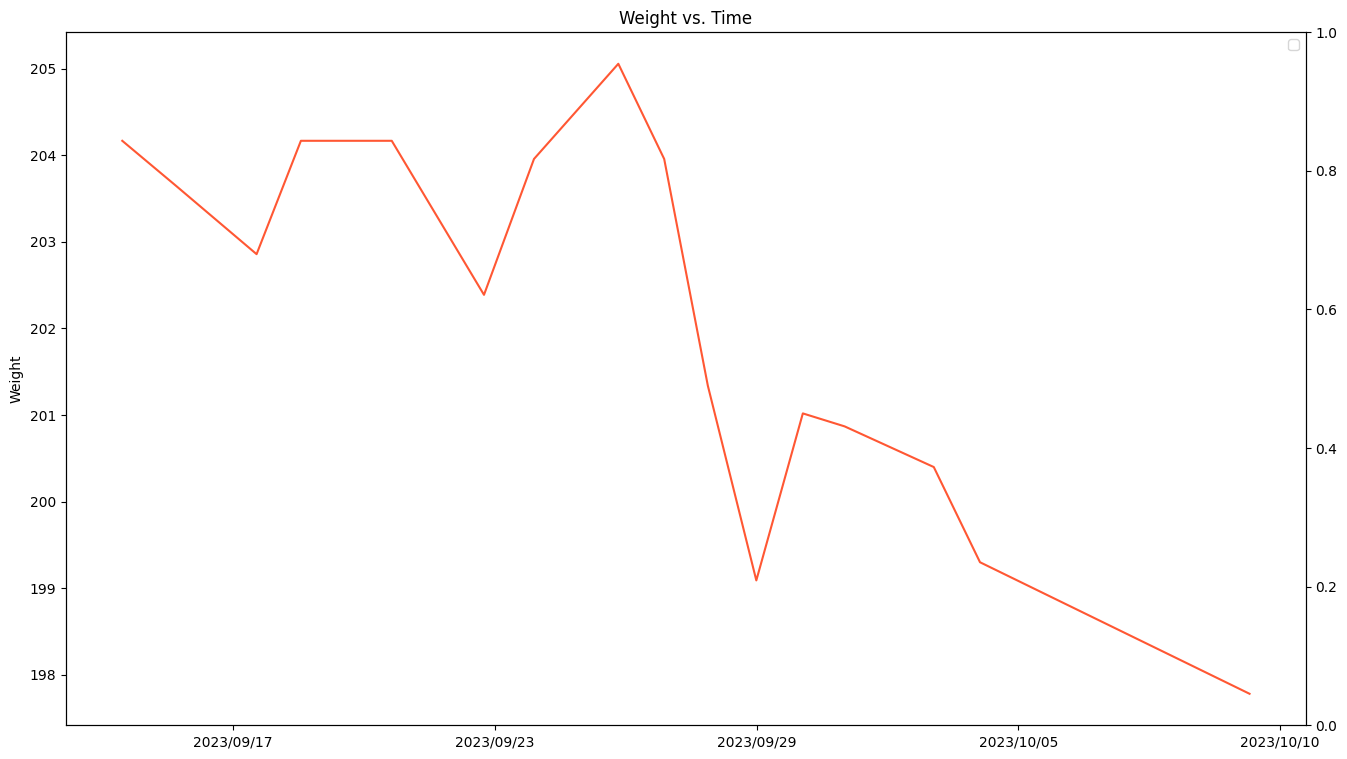

In [235]:

plot_variables(weight, "start_time", ["weight"], True, title="Weight vs. Time", convert_to_date=True)

## Sleep

In [255]:

sleep = pd.read_csv(galaxy_watch_folder_dir + "sleep.csv", index_col=False)

columns_to_remove = ["comment", "datauuid", "custom","deviceuuid","pkg_name", "original_efficiency", "extra_data", "quality", "original_bed_time", "create_time", "update_time", "combined_id", "has_sleep_data", "sleep_type", "data_version"]
remove_prefix = lambda x: x.replace("com.samsung.health.sleep.", "")

# Remove columns from sleep

# Rename the columns using the lambda function
sleep = sleep.rename(columns=remove_prefix)
sleep = sleep.drop(columns=columns_to_remove)
sleep["sleep_duration"] = sleep["sleep_duration"].apply(lambda x: float(x) / 60)
print(sleep.columns)
# Change starttime so its local timzone
sleep = do_the_rudamentary_time_changes(sleep, use_end_time_for_date=True)

daily_sleep = sum_df_by_variable(sleep, "date", ["sleep_duration", "day_of_the_week", "start_time", "sleep_score", "efficiency", "mental_recovery", "physical_recovery"], ["sum", "first", "mean", "mean", "mean", "mean", "mean"])
daily_sleep.sort_values(by="sleep_duration", ascending=False)

Index(['mental_recovery', 'factor_01', 'factor_02', 'factor_03', 'factor_04',
       'factor_05', 'factor_06', 'factor_07', 'factor_08', 'factor_09',
       'factor_10', 'physical_recovery', 'original_wake_up_time',
       'movement_awakening', 'sleep_cycle', 'efficiency', 'sleep_score',
       'sleep_duration', 'start_time', 'time_offset', 'end_time'],
      dtype='object')


,sleep_duration,day_of_the_week,start_time,sleep_score,efficiency,mental_recovery,physical_recovery
date,,,,,,,
2023/09/16,9.216667,5,1.694854e+09,62.5,87.0,65.5,34.5
2023/09/18,9.216667,0,1.695008e+09,70.0,86.0,44.0,73.0
2023/10/01,9.116667,6,1.696130e+09,71.0,91.0,62.0,72.0
2023/10/07,8.983333,5,1.696651e+09,76.0,88.0,87.0,69.0
2023/10/05,8.833333,3,1.696490e+09,60.0,81.5,57.0,39.0
2023/10/06,8.733333,4,1.696570e+09,63.0,79.0,20.0,63.0
2023/09/20,8.600000,2,1.695180e+09,70.0,90.0,70.0,59.0
2023/09/28,8.566667,3,1.695872e+09,71.0,89.0,79.0,70.0
2023/09/24,8.566667,6,1.695529e+09,72.0,91.0,57.0,79.0


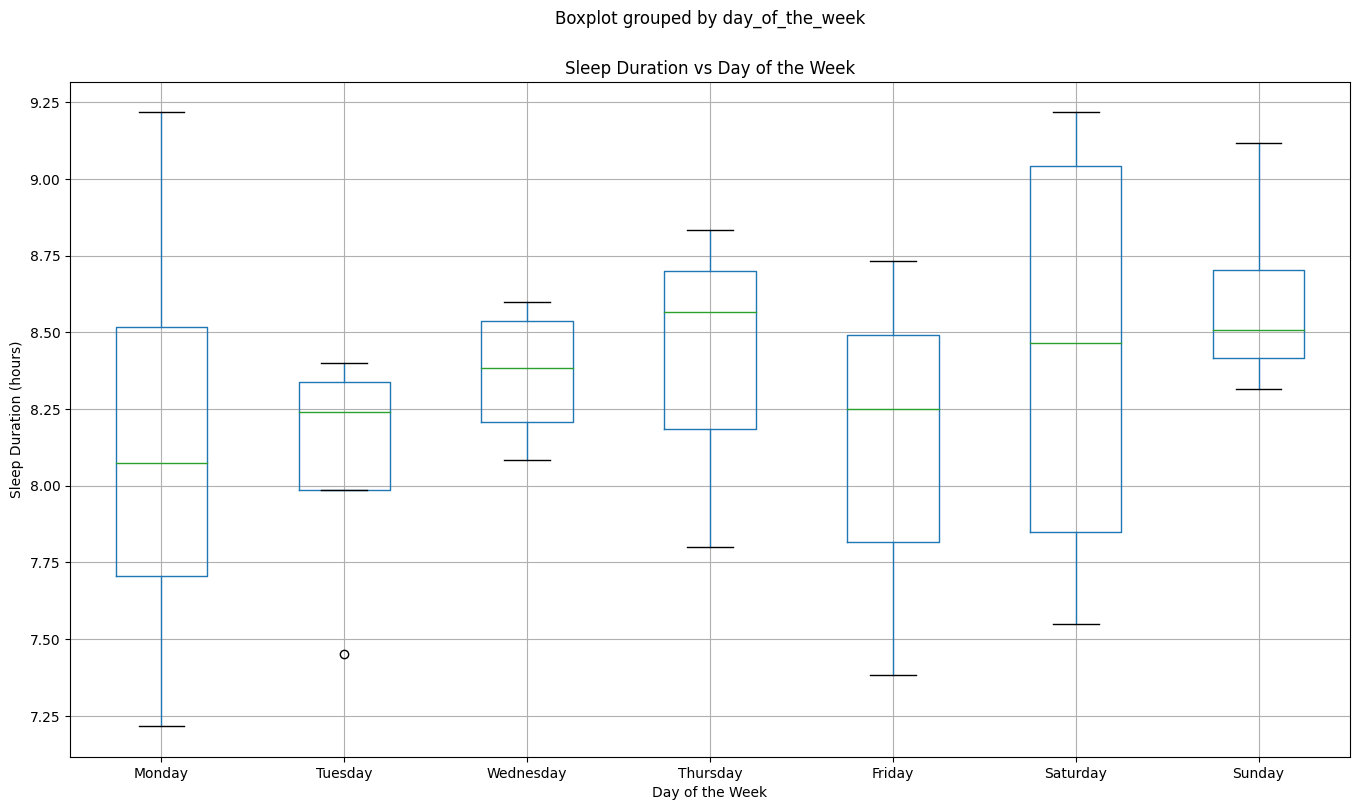

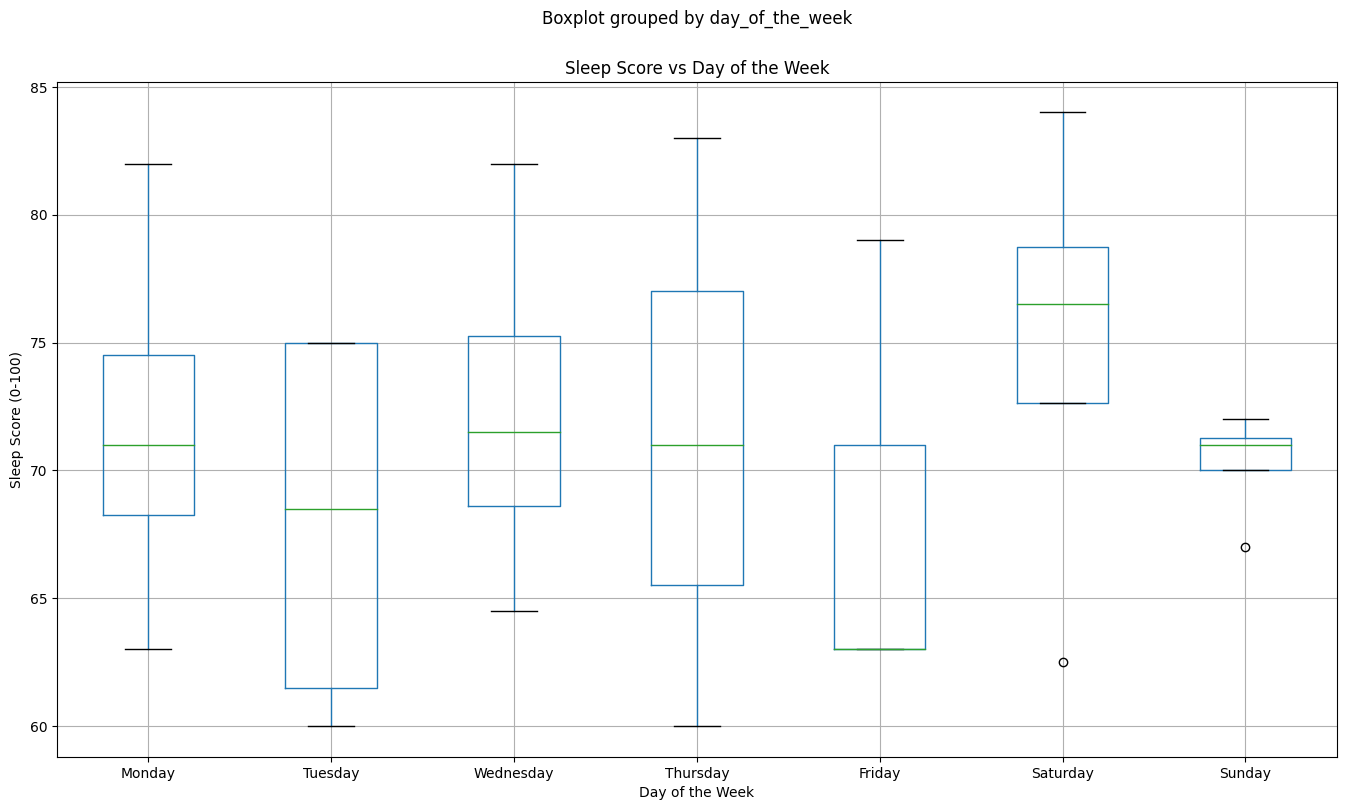

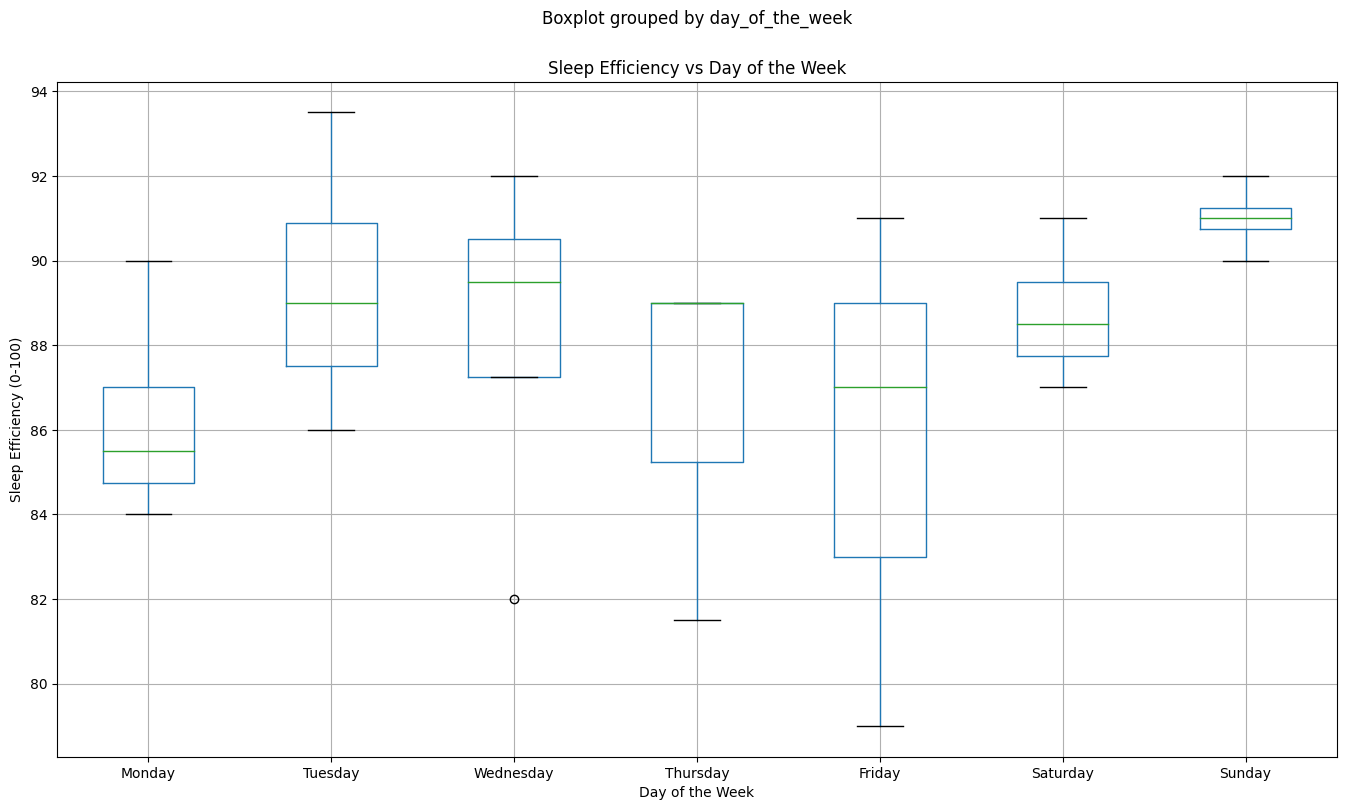

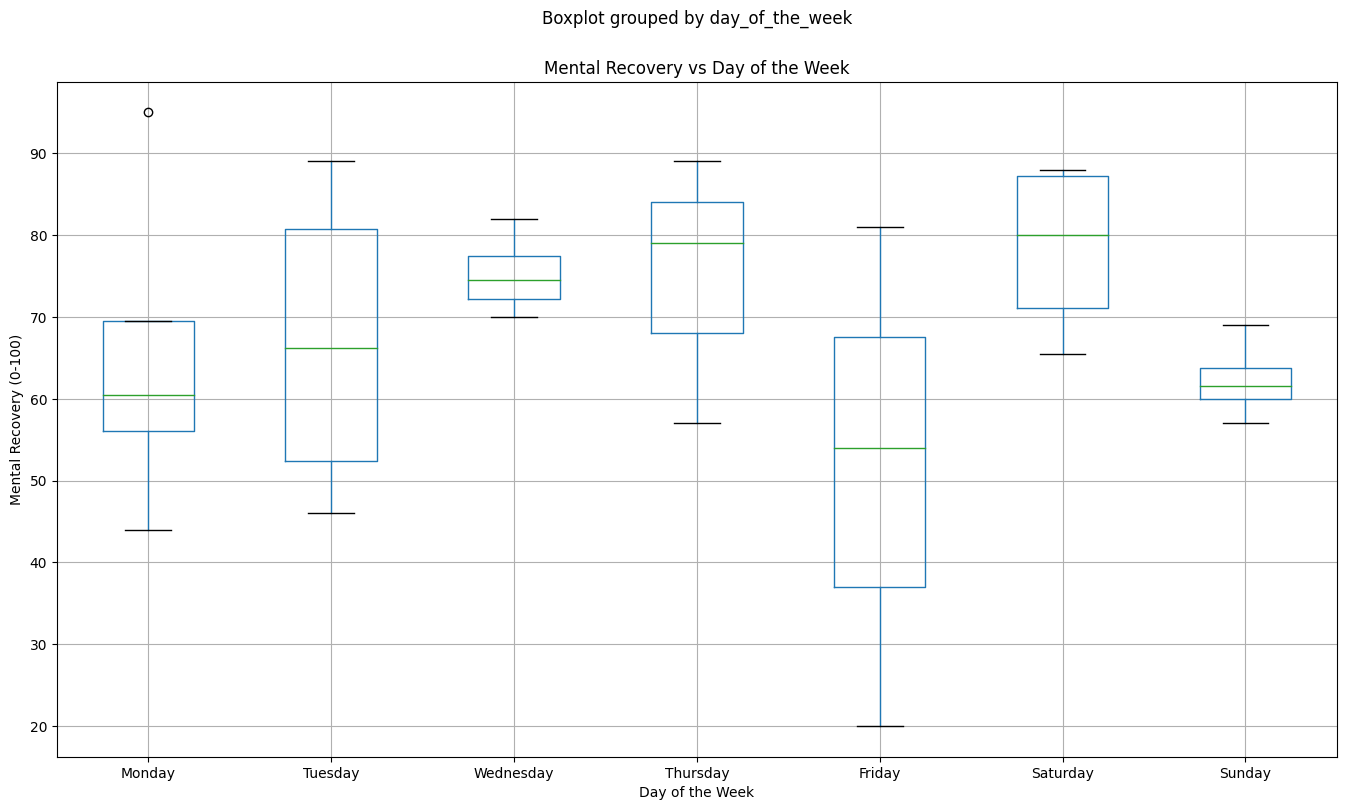

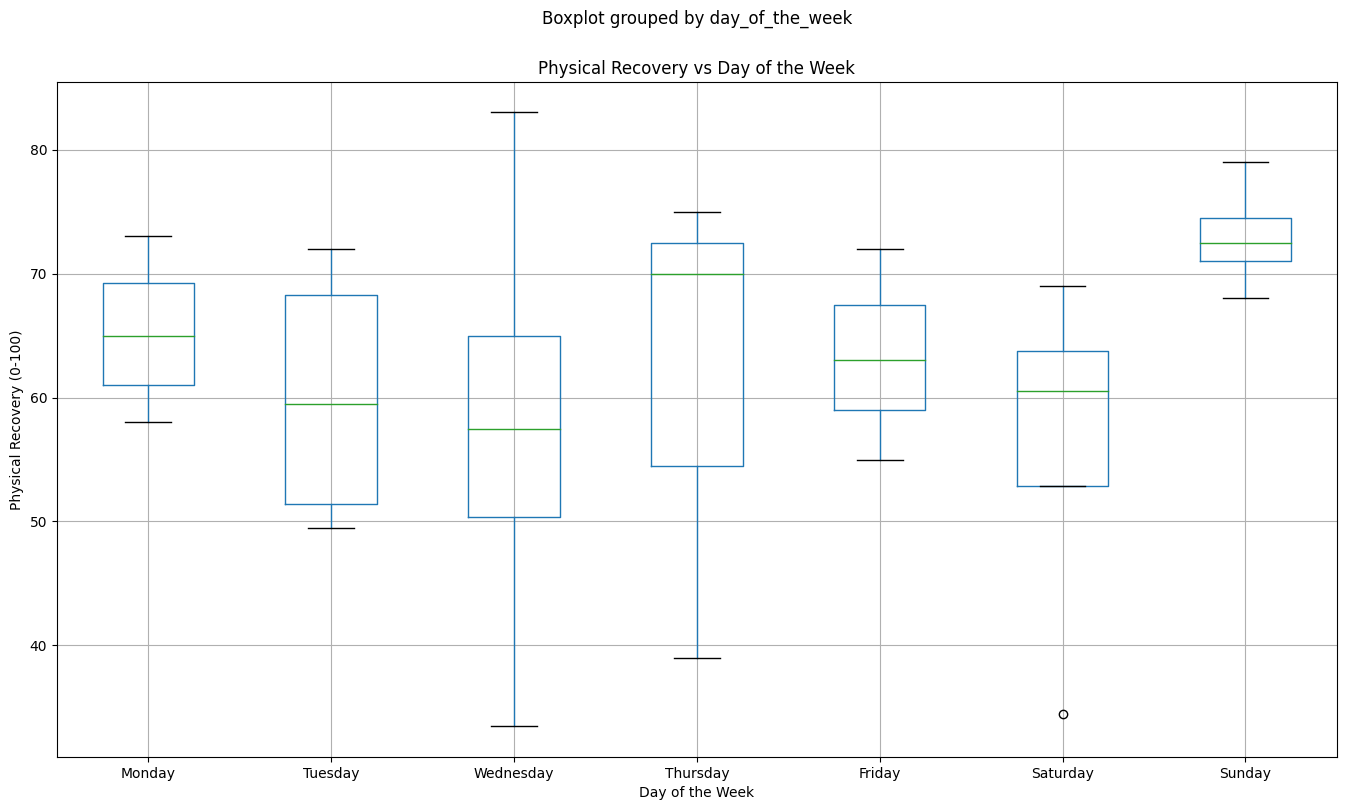

In [254]:
# Plot box and whisker chart for day of the week and amount slept

plot_box_and_whisker(daily_sleep, "day_of_the_week", "sleep_duration", "Sleep Duration vs Day of the Week", "Day of the Week", "Sleep Duration (hours)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "sleep_score", "Sleep Score vs Day of the Week", "Day of the Week", "Sleep Score (0-100)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "efficiency", "Sleep Efficiency vs Day of the Week", "Day of the Week", "Sleep Efficiency (0-100)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "mental_recovery", "Mental Recovery vs Day of the Week", "Day of the Week", "Mental Recovery (0-100)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "physical_recovery", "Physical Recovery vs Day of the Week", "Day of the Week", "Physical Recovery (0-100)")

/tmp/ipykernel_484011/1518511680.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


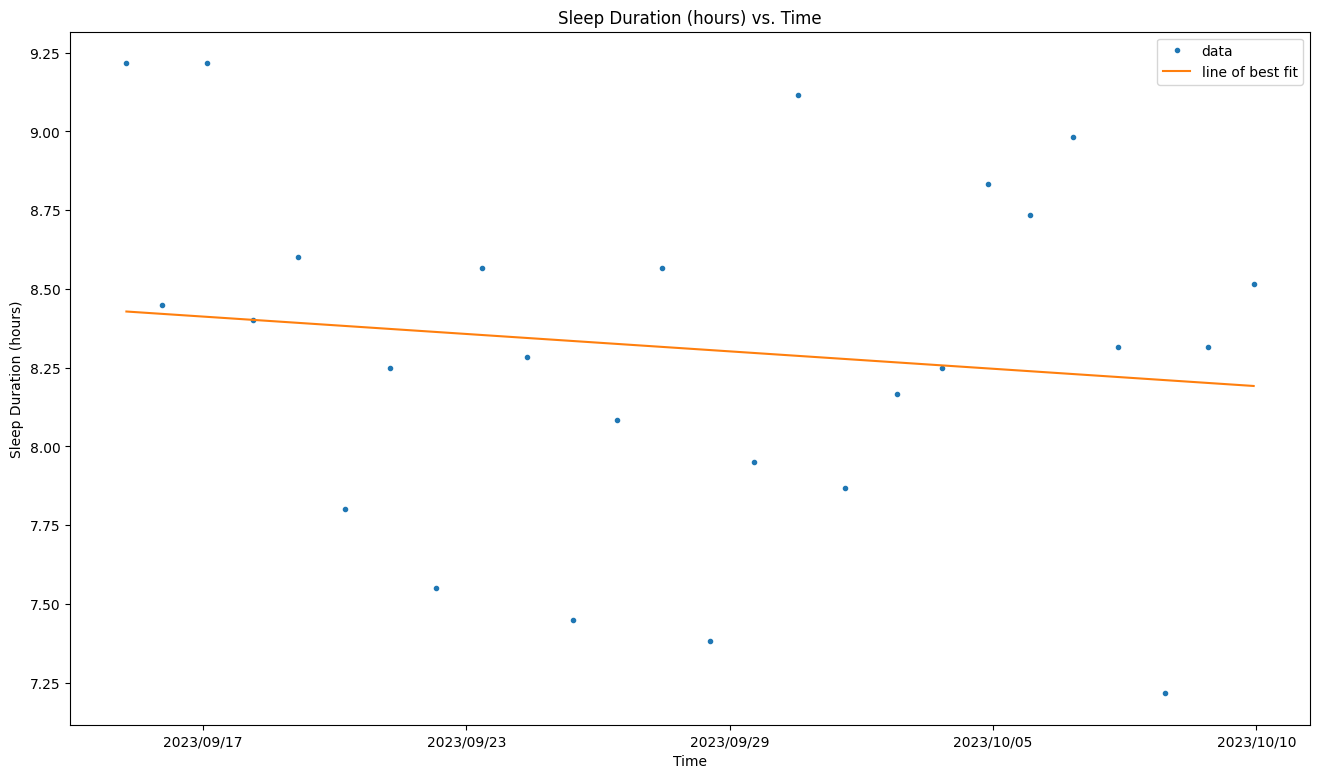

In [181]:
  
# plot_scatter(sleep, "com.samsung.health.sleep.start_time","sleep_duration")
plot_line_of_best_fit(daily_sleep, "start_time","sleep_duration", "Sleep Duration (hours) vs. Time", "Time", "Sleep Duration (hours)")

# Stress

In [182]:
stress = pd.read_csv(galaxy_watch_folder_dir + "stress.csv", index_col=False)
stress = stress.rename(columns=remove_prefix)
columns_to_remove = ["custom",	"binning_data",	"tag_id",	"create_time",	"algorithm",	"deviceuuid",	"comment",	"pkg_name",	"datauuid"]
stress = stress.drop(columns=columns_to_remove)

stress = do_the_rudamentary_time_changes(stress)
stress["hour"] = stress["start_time"].apply(lambda x: datetime.fromtimestamp(x).hour)
stress.head(10)
daily_stress = sum_df_by_variable(stress, "date", ["score", "max", "min", "score", "day_of_the_week"], ["mean"])
daily_stress

,score,max,min,day_of_the_week
date,,,,
2023/09/15,7.882353,41.117647,0.823529,4.0
2023/09/16,7.437500,41.250000,0.187500,5.0
2023/09/17,12.933333,55.066667,0.666667,6.0
2023/09/18,18.500000,61.687500,0.812500,0.0
2023/09/19,18.562500,60.500000,0.937500,1.0
2023/09/20,8.750000,61.187500,0.187500,2.0
2023/09/21,14.705882,58.823529,0.411765,3.0
2023/09/22,16.882353,67.529412,1.294118,4.0
2023/09/23,9.437500,48.937500,0.375000,5.0


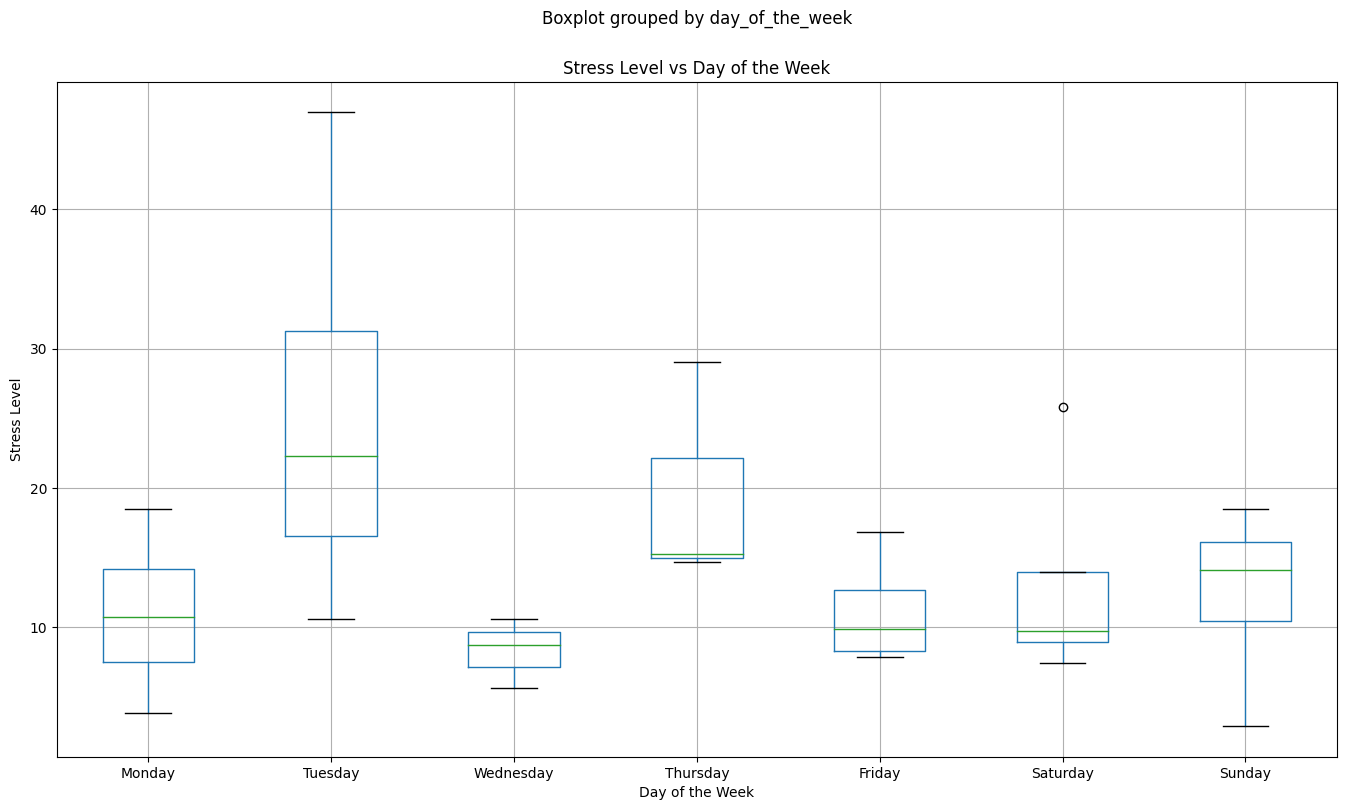

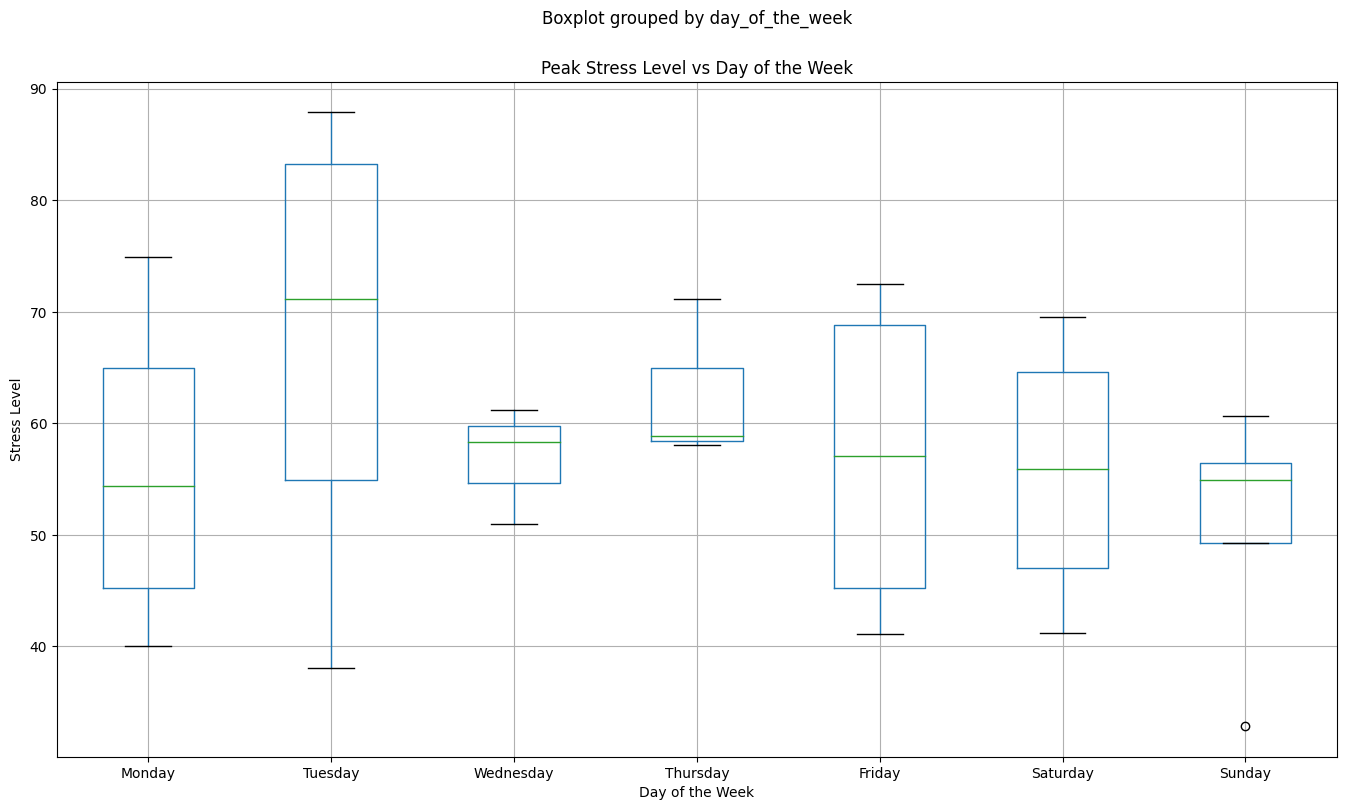

In [183]:
plot_box_and_whisker(daily_stress, "day_of_the_week", "score", "Stress Level vs Day of the Week", "Day of the Week", "Stress Level")
plot_box_and_whisker(daily_stress, "day_of_the_week", "max", "Peak Stress Level vs Day of the Week", "Day of the Week", "Stress Level")

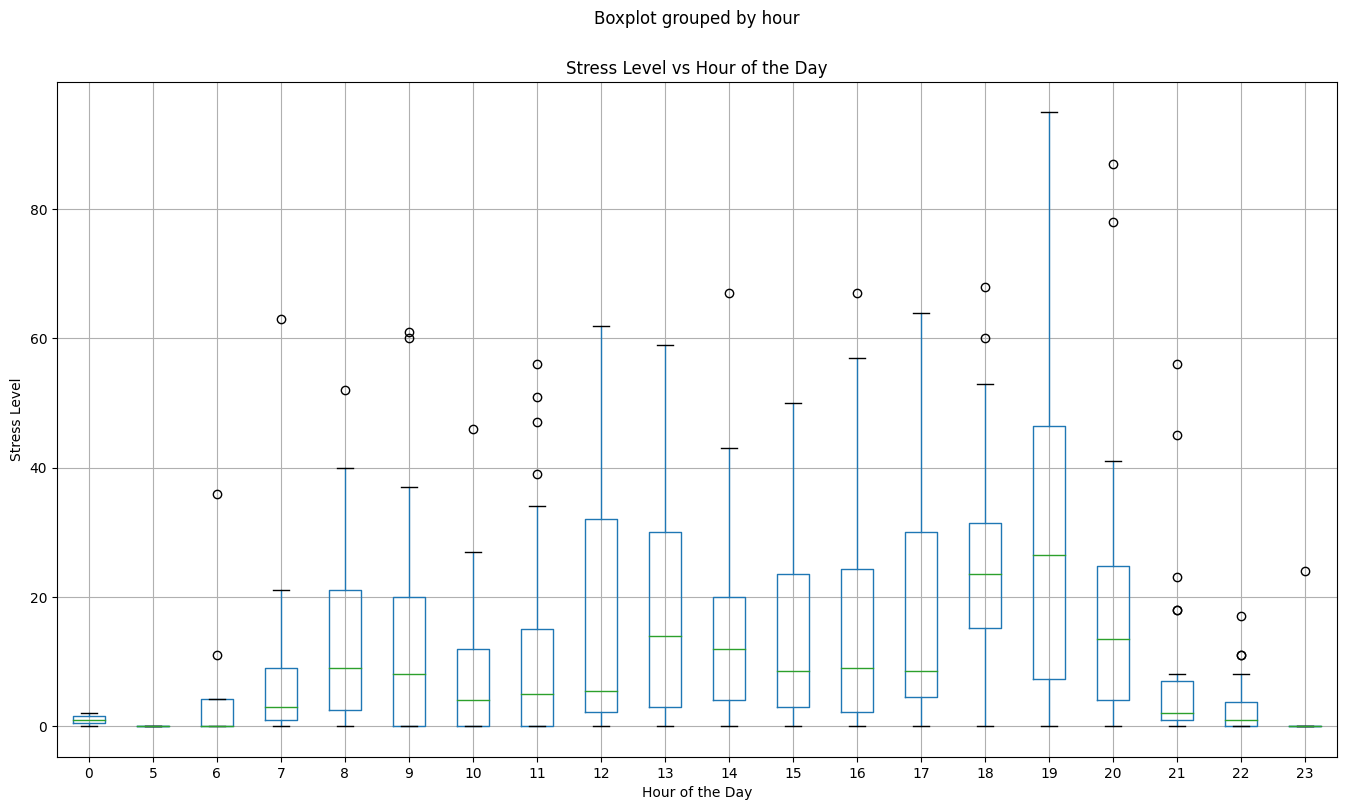

In [184]:
plot_box_and_whisker(stress, "hour", "score", "Stress Level vs Hour of the Day", "Hour of the Day", "Stress Level")

/tmp/ipykernel_484011/4147503299.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels)
/tmp/ipykernel_484011/4147503299.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + [str(z) + ":00" for z in range(6, 24, 2)])


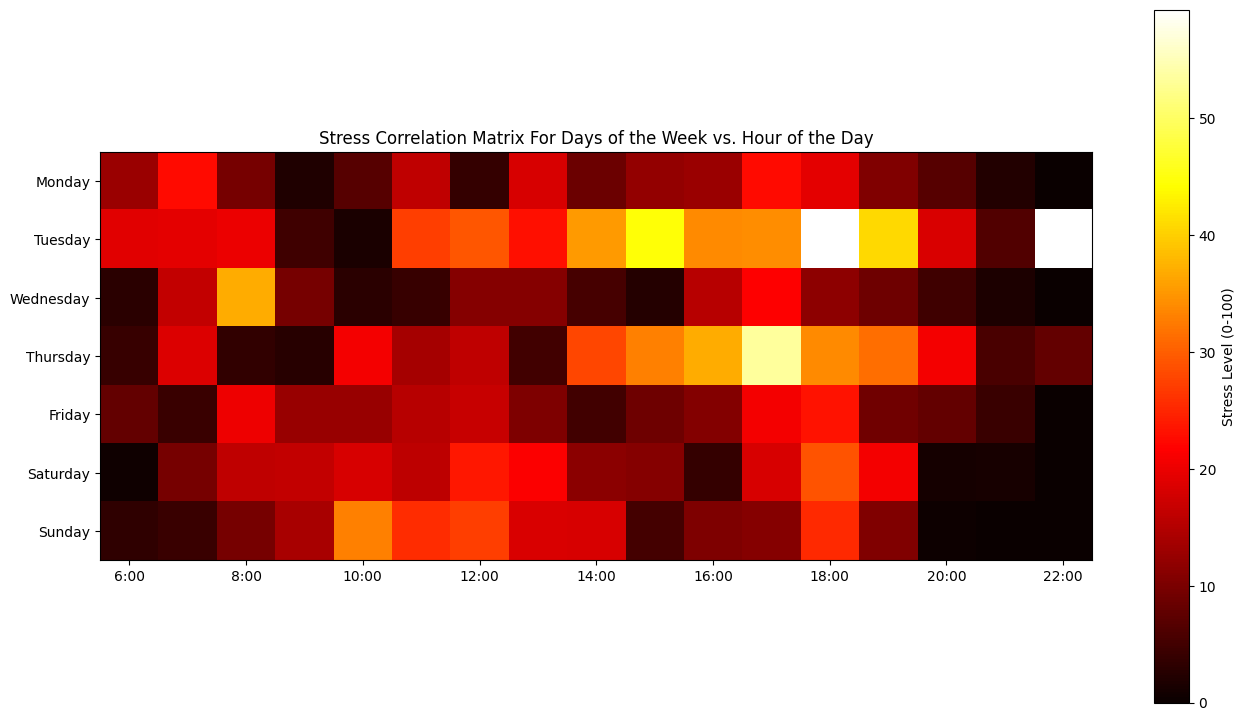

In [239]:
def plot_matrix(dataframe: pd.DataFrame, x_axies, y_axis, title):
  # This function will be used to see the average stress given a specific hour and given a specific day
  assert len(x_axies) == 2
  fig, ax = plt.subplots(figsize=(16, 9))

  avg_stress = dataframe.groupby([x_axies[0], x_axies[1]])[y_axis].mean()

  # convert the resulting series to a matrix with days as rows and hours as columns
  matrix = avg_stress.unstack(level=1)
  
  im = ax.imshow(matrix, cmap="hot", interpolation="nearest")
  
  # convert the x axis into days of the week

  new_labels = ["","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  ax.set_yticklabels(new_labels)
  ax.set_xticklabels([""] + [str(z) + ":00" for z in range(6, 24, 2)])
  ax.set_title(title)
  
  colorbar = ax.figure.colorbar(im, ax=None)
  colorbar.set_label("Stress Level (0-100)")
  savefig(title, type_="matrix")

plot_matrix(stress[stress["hour"] > 6], ["day_of_the_week", "hour"], "score",  "Stress Correlation Matrix For Days of the Week vs. Hour of the Day")

# Computer Usage

In [22]:
data = json.loads(open(computer_usage_folder_dir + "aw-bucket-export_aw-watcher-window_matts-computer.json").read())

In [113]:
computer_usage_raw = pd.DataFrame(data["buckets"]["aw-watcher-window_matts-computer"]["events"])
computer_usage_raw["start_time"] = computer_usage_raw["timestamp"].apply(lambda string: string.split("+")[0].split(".")[0]).apply(convert_datetime_to_time_since_last_epoch) - 5 * 3600



computer_usage_raw["timestamp"] = computer_usage_raw["start_time"].apply(convert_time_since_last_epoch_to_date)
computer_usage_raw.sort_values(by="start_time",ascending=False )

computer_usage_raw = do_the_rudamentary_time_changes(computer_usage_raw)
computer_usage = sum_df_by_variable(computer_usage_raw, "date", ["duration", "day_of_the_week", "start_time"], ["mean", "first", "max"])
computer_usage["last_time_used"] = computer_usage["start_time"]
computer_usage["start_time"] = (computer_usage["start_time"]).apply(convert_time_since_last_epoch_to_date).apply(convert_datetime_to_time_since_last_epoch)
computer_usage["last_time_used"] = (abs(computer_usage["start_time"] - computer_usage["last_time_used"])) / 3600

Index(['timestamp', 'duration', 'data', 'start_time'], dtype='object')


## Computer Usage vs. Sleep

In [137]:
compute_correlation(computer_usage, daily_sleep, "index", ["last_time_used", "sleep_score"])

0.39685054228772626

In [120]:
computer_usage["datetime"] = computer_usage["start_time"].apply(convert_time_since_last_epoch_to_date)
daily_sleep["datetime"] = daily_sleep["start_time"].apply(convert_time_since_last_epoch_to_date)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


    duration  day_of_the_week_x  start_time_x  last_time_used    datetime  \
0  36.003776                  0  1.693804e+09        9.852500  2023/09/04   
1  17.191497                  1  1.693890e+09       21.798333  2023/09/05   
2  16.572441                  2  1.693976e+09       22.260833  2023/09/06   
3  17.063946                  3  1.694063e+09       22.884722  2023/09/07   
4  15.711448                  4  1.694149e+09       13.805556  2023/09/08   

   sleep_duration  day_of_the_week_y  start_time_y  sleep_score  
0       14.883333                  0  1.693845e+09         69.5  
1        8.850000                  2  1.693970e+09         78.0  
2        8.283333                  3  1.694058e+09         78.0  
3        7.866667                  4  1.694148e+09         70.0  
4       10.066667                  5  1.694233e+09         52.0  
last_time_used  is  #FF5733
sleep_score  is  #40E0D0


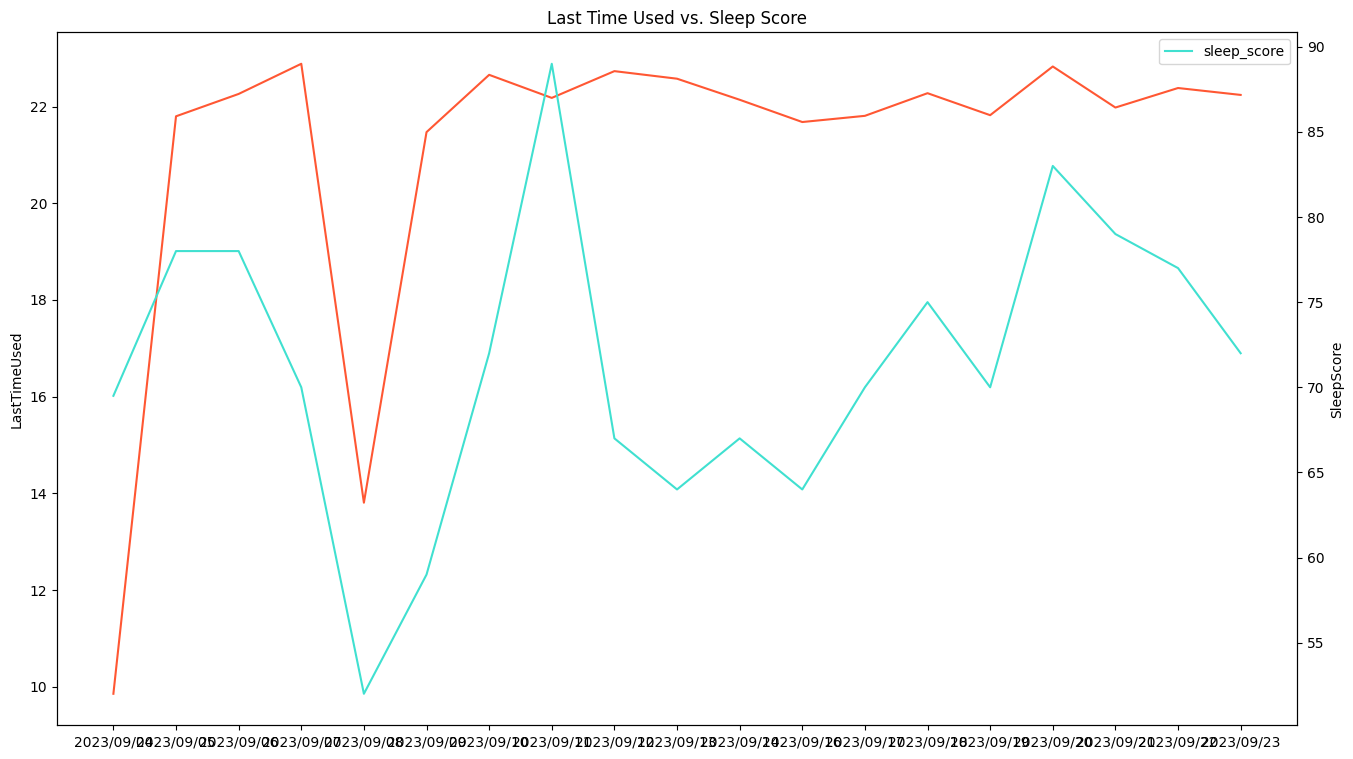

In [135]:
merged = pd.merge(computer_usage, daily_sleep, on="datetime")
print(merged.head(5))
plot_variables(merged, "datetime", ["last_time_used", "sleep_score"], True, "Last Time Used vs. Sleep Score")

# Exercise

In [155]:
exercise = pd.read_csv(galaxy_watch_folder_dir + "exercise.csv", index_col=False)
columns_to_remove = ["subset_data", "routine_datauuid", "activity_type", "title", "tracking_status", "source_type", "reward_status", "mission_extra_value", "program_schedule_id", "program_id", "mean_caloricburn_rate", "heart_rate_deviceuuid", "live_data_internal", "mission_value", "pace_info_id", "pace_live_data", "mission_type", "location_data_internal", "additional_internal", "min_altitude", "max_altitude", "deviceuuid","completion_status" , "comment", "location_data", "sensing_status", "incline_distance", "decline_distance", "live_data", "datauuid", "max_cadence", "altitude_gain", "update_time", "create_time"]
remove_prefix = lambda x: x.replace("com.samsung.health.exercise.", "")

exercise_type_number_to_string_map = {
  15002 : "Weight Lifting",
  1002 : "Running",
  1001 : "Walking",
  5001 : "Volleyball",
  11007 : "Cycling",
  0 : "UNKNOWN"
}

exercise = exercise.rename(columns=remove_prefix)

exercise = exercise.drop(columns = columns_to_remove)
exercise = do_the_rudamentary_time_changes(exercise)
print(exercise.head(10))
exercise["duration"] /= 1000

# use the exercise_type_number_to_string_map
exercise["exercise_type"] = exercise["exercise_type"].apply(lambda x: exercise_type_number_to_string_map[x])


Index(['total_calorie', 'heart_rate_sample_count', 'custom_id', 'duration',
       'additional', 'start_time', 'exercise_type', 'custom',
       'mean_heart_rate', 'count_type', 'mean_rpm', 'max_heart_rate',
       'max_power', 'max_speed', 'mean_cadence', 'min_heart_rate', 'count',
       'distance', 'max_caloricburn_rate', 'calorie', 'vo2_max', 'time_offset',
       'max_rpm', 'mean_power', 'mean_speed', 'pkg_name', 'altitude_loss',
       'exercise_custom_type', 'end_time', 'sweat_loss'],
      dtype='object')
    total_calorie  heart_rate_sample_count  custom_id  duration  additional  \
57      264.26312                   1969.0        NaN   2009231         NaN   
30      173.04443                   1113.0        NaN   1148232         NaN   
84      441.23956                   2817.0        NaN   2859605         NaN   
58      171.03308                   1133.0        NaN   1151296         NaN   
56      183.55724                   1214.0        NaN   1238599         NaN   
50     

## Exercise & Sleep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


            sleep_duration  day_of_the_week    start_time  sleep_score  \
date                                                                     
2023/09/16       17.666667                5  1.694877e+09         64.0   
2023/09/17        9.216667                0  1.695008e+09         70.0   
2023/09/18        8.400000                1  1.695095e+09         75.0   
2023/09/19        8.600000                2  1.695180e+09         70.0   
2023/09/20        7.800000                3  1.695269e+09         83.0   

              datetime  worked_out  
date                                
2023/09/16  2023/09/16         1.0  
2023/09/17  2023/09/17         1.0  
2023/09/18  2023/09/18         0.0  
2023/09/19  2023/09/19         1.0  
2023/09/20  2023/09/20         0.0  
worked_out  is  #FF5733
sleep_score  is  #40E0D0


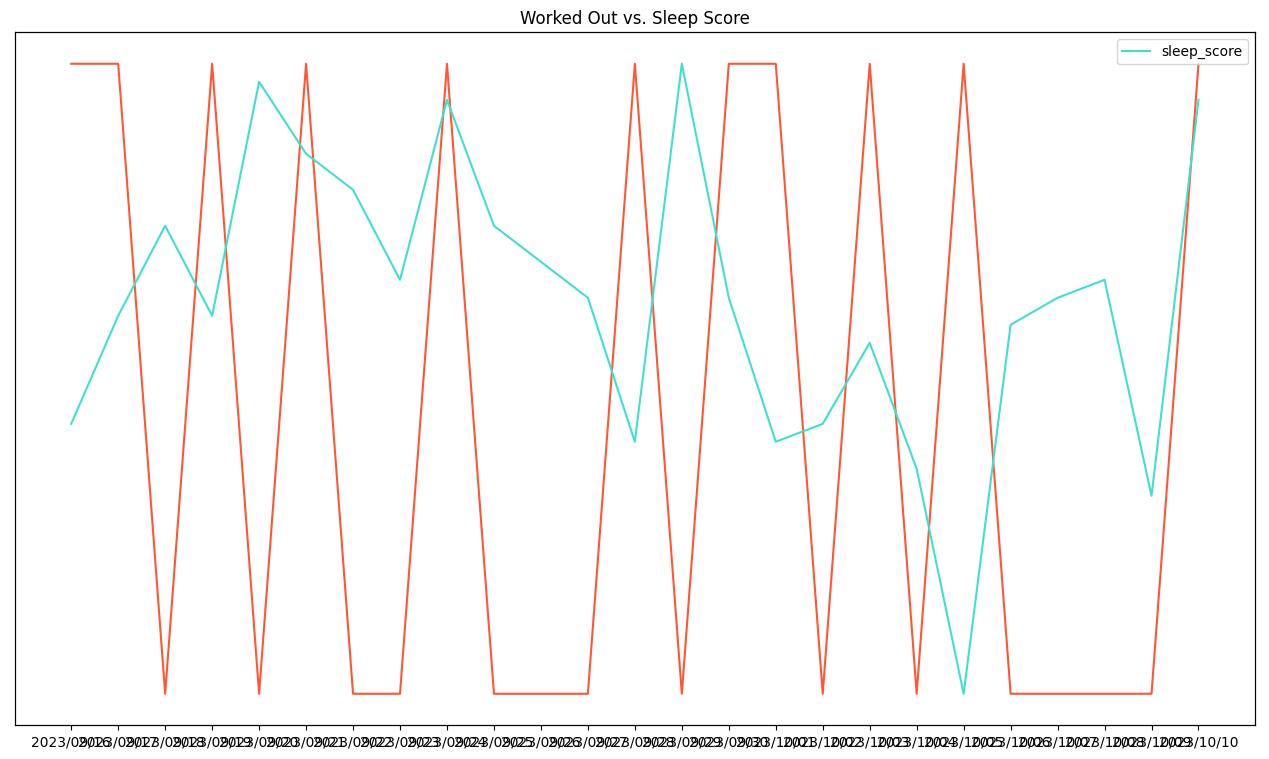

In [158]:
# Find days when we go to the gym (weight lifting)

days_worked_out = exercise[exercise["exercise_type"] == "Weight Lifting"]["date"].unique()

print(daily_sleep.head(5))
daily_sleep["datetime"] = daily_sleep["start_time"].apply(convert_time_since_last_epoch_to_date)
daily_sleep["worked_out"] = daily_sleep["datetime"].apply(lambda x: float(x in days_worked_out))

daily_sleep["worked_out"].corr(daily_sleep["sleep_score"])

# Weight Lifting

In [4]:
data_file_path = exercise_logs_folder_dir + "gym_data_2022.txt"
raw = ""
with open(data_file_path, "r") as f:
  raw = f.read()

# Split by paragraph
raw = raw.split("\n\n")

# Clean data
raw = [r.lower() for r in raw]
print(raw)

import json

def get_first_non_alpha_character_index(string):
  for i, c in enumerate(string):
    if not c.isalpha() and c != " ":
      return i
  raise Exception("No non-alpha characters found in " + repr(string))

exercises = {}
with open(exercise_logs_folder_dir + "exercise_aliases.json", "r") as f:
  exercises = json.loads(f.read())

raw_exercises = [line.split("\n")[1:] for line in raw]

# flatten all_exercises array

raw_exercises = [item for sublist in raw_exercises for item in sublist]

# remove empty strings
raw_exercises = [x for x in raw_exercises if x and x != " "]

all_exercise_names = []
for exercise in raw_exercises:
  print(exercise)
  all_exercise_names.append(exercise[:get_first_non_alpha_character_index(exercise)])
all_exercise_names = [z.strip() for z in all_exercise_names]

['16/5/22\nlat pulldown 85 - 12\nrope pulldown - 30 - 12', '23/5/22 (push)\nrope pull down - 40 - 8\nbench press - 40 - 8\nlat raise- 15 - 8\ninclined dumbell - 17.5 - 8', '24/5/22 (pull):\nlat pulldown 90 - 12; 100 - 10; 100 - 8\nseated row - 70 - 8\nbicept curls - 40 - 8\npull up assist: 100 - 8 (good form :))', "25/5/22 (leg)\nleg extension 110 - 12 ; 120 - 10; 130 - 9\nleg curl - 125-12; 135-10; 140 - 8 (struggling at 8)\ncalf raises - 30 - 25, 25, 25;\nsquat - 100 - 12 (easy peezy)\nleg press - 180 - 12 (ehhh not bad); 230 - 10; 250 - 25 (you're crazy)", '27/5/22 (pull)\nseated row - 75 - 12;  85 - 10; 85 - 8\nlat pulldown (better form) - 70 - 15; 75 - 10; 75 - 8\nbench press - 40 - 12; 50 - 10; 50 - 8\nincline bench press - 15 - 15, 15, 15', '29/5/22 (push)\nincline bench - 20 - 12, 10; 25 - 8\nshoulder press - 20 - 12,10\nbench - 40 - 12; 50 - 10; 55 - 8\ntricept pulldown - 20 - 12,10,8\nlat raises - 15 - 12; 17.5 - 10,8', '31/5/22 (leg)\nleg curl 130-12; 140-10; 150 - 8\nleg ex

## Run this whenever importing new data to see if there are any new exercises

In [5]:

for exercise in all_exercise_names:
  exists = False
  for exercise_type in exercises:
    if exercise in exercises[exercise_type]:
      exists = True
      break
  if not exists:
    answer = input("Ayo, we couldn't find an alias for " + exercise + ". What should its alias be?\nOptions:" + str(list(exercises.keys())) + "\n")
    exercise = exercise.strip()
    answer = answer.strip()
    if answer in exercises:
      exercises[answer].append(exercise)
    else:
      ohOh = input("We couldn't find " + answer + " in the list of exercise types. Should we add it?\n")
      if "y" in ohOh:
        exercises[answer] = [exercise]
      else:
        print("We didn't add the exercise:\t" + exercise)

response = input("Do you want to save this data? (y/n)\n")
if "y" in response:
  with open(exercise_logs_folder_dir + "exercise_aliases.json", "w") as f:
    f.write(json.dumps(exercises, indent=2)) 

KeyboardInterrupt: Interrupted by user

In [6]:

# Turn date into a time object
def convert_date_to_days(date):
  if type(date) == list:
      if len(date) == 1:
        date = date[0]
      else:
        raise Exception("Homie wrong data type", date)
  try:
    if "-" in date:
      date = date.split('-')
    elif "/" in date:
      date = date.split('/')
    else:
      raise Exception("Homie wrong date", date)
    year = int(date[2])
    month = int(date[1])
    day = int(date[0])
    return (year - 22) * 365 + month * 30.5 + day
  except:
     print(date)
     raise Exception("Error: " + date)

def get_first_non_number_or_space_index(string):
    for i in range(len(string)):
        if not string[i].isdigit() and string[i] != ' ' and string[i] != "/":
            return i
    return -1

def get_first_number(string):
    if len(string) == 0:
       raise Exception("Not a proper string, length is 0")
    
    for i in range(len(string)):
        if string[i].isdigit():
            start_index = i
            break
    else:
       raise ValueError(string + " does not have a number!")
    for i in range(start_index, len(string)):
        if not string[i].isdigit() and string[i] != ".":
            return string[start_index:i]
    return string[start_index:]

class Set:
   def __init__(self):
      self.weight = 0
      self.reps = 0

class Workout:
   def __init__(self, day, sets):
      self.day = day
      self.sets = sets

def get_set_info_from_string(string):
  string = string.strip()
  sets = [Set() for i in range(len(string.split(",")))]
  weight = get_first_number(string)
  remainding_string = string[string.index(weight) + len(weight):]
  for i in range(len(sets)):
    sets[i].weight = float(weight)
    reps = get_first_number(remainding_string)
    sets[i].reps = float(reps)
    remainding_string = remainding_string[remainding_string.index(reps) + len(reps):]
    # print("Weight: ", sets[i].weight, "Reps: ", reps)
  return sets
 
workouts = [] 
previous_day_of_workout = -999999
for i in range(len(raw)):
  day_of_workout = (convert_date_to_days(raw[i][:get_first_non_number_or_space_index(raw[i])]))
  if day_of_workout < previous_day_of_workout:
    print("Error: ", raw[i])
  exercises_on_that_day = raw[i].split("\n")[1:]
  exercises_on_that_day = [exercise for exercise in exercises_on_that_day if exercise != '']
  sets = []
  for exercise in exercises_on_that_day:
    exercise_type = exercise[:get_first_non_alpha_character_index(exercise)]
    exercise_type = exercise_type.strip()

    for possible_exercise_type in exercises:
      if exercise_type in exercises[possible_exercise_type]:
        exercise_type = possible_exercise_type
        break
    
    # if possible_exercise_type == "bench press":
    if exercise_type == "lat pulldown":
      print("For day of", raw[i][:get_first_non_number_or_space_index(raw[i])], "exercise type is", exercise_type)
      exercise_set = exercise[get_first_non_alpha_character_index(exercise):].split(";")
      exercise_set = [set.strip() for set in exercise_set]
      exercise_set = [set for set in exercise_set if set != '']
      for set in exercise_set:
        # print(set)
        if set[0] == "-":
          set = set[1:]
        # sets.extend(get_set_info_from_string(set))
        for set in get_set_info_from_string(set):
          sets.append(set)
      print(len(sets))
      workouts.append(Workout(day_of_workout, sets))
    
    previous_day_of_workout = day_of_workout

  # print(exercises_on_that_day)


For day of 16/5/22 exercise type is lat pulldown
1
For day of 24/5/22  exercise type is lat pulldown
3
For day of 27/5/22  exercise type is lat pulldown
3
For day of 3/6/22  exercise type is lat pulldown
3
For day of 7/6/22  exercise type is lat pulldown
1
For day of 11/6/22  exercise type is lat pulldown
3
For day of 19/6/22  exercise type is lat pulldown
4
For day of 23/6/22  exercise type is lat pulldown
3
For day of 30/6/22  exercise type is lat pulldown
3
For day of 4/7/22  exercise type is lat pulldown
4
For day of 9/7/22  exercise type is lat pulldown
4
For day of 22/7/22  exercise type is lat pulldown
3
For day of 29/7/22  exercise type is lat pulldown
3
Error:  3/7/22 (legs):
leg extensions - 200 - 7, 7,8;
leg curls - 200
For day of 6/7/22  exercise type is lat pulldown
4
For day of 10/7/22  exercise type is lat pulldown
4
For day of 27/7/22  exercise type is lat pulldown
4


[(190.0, 78.57142857142857)]


array([-6.31939752e-04,  7.91864985e-01, -3.57912093e+00])

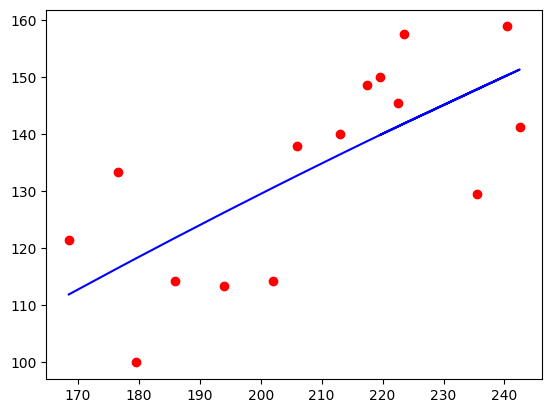

In [20]:
def reps_to_one_rep_max(rep):
    return 1 - rep / 40

days = []
metrics = []

for workout in workouts:
    if any([set.reps <= 12 for set in workout.sets]):
        days.append(workout.day)
        metrics.append(max([set.weight / reps_to_one_rep_max(set.reps) for set in workout.sets if set.reps <= 12]))


fit_of_x = np.polyfit(days, metrics, 2)

### Use the fit of x to extract any outliers
outliers = []
for day, metric in zip(days, metrics):
    if metric > np.polyval(fit_of_x, day) * 1.25:
        outliers.append((day, metric)) 
    if metric < np.polyval(fit_of_x, day) * 0.8:
        outliers.append((day, metric)) 
print(outliers)

## remove the outlier from the dataset
for outlier in outliers:
    days.remove(outlier[0])
    metrics.remove(outlier[1])

fit_of_x = np.polyfit(days, metrics, 2)
plt.plot(days, metrics, 'ro')
plt.plot(days, np.polyval(fit_of_x, days), 'b-')

# All Data

In [ ]:
# all_daily_data = 

## Calendar

In [371]:
from datetime import datetime
from ics import Calendar
from math import ceil
# Open the .ics file and read its contents into a string variable
with open(calendar_events_folder_dir + '/handzelmatthew@gmail.com.ics', 'r') as f:
    calendar_str = f.read()

# Create a new Calendar object and parse the contents of the .ics file into it
calendar = Calendar()

# Concatenate all of the calendars in the calendar_events_folder_dir

for file in os.listdir(calendar_events_folder_dir):
  if file.endswith(".ics"):
    with open(calendar_events_folder_dir + "/" + file, 'r') as f:
      calendar_str = f.read()
    c = Calendar(calendar_str)
    calendar.events.update(c.events)


In [373]:
events = pd.DataFrame()

# load the previous map if it exists
previous_map = {}
with open(calendar_events_folder_dir + "/event_classification.json", "r") as f:
    previous_map = json.loads(f.read())


# Filer calendar events
to_remove = []
for event in calendar.events:
  if event.all_day:
    to_remove.append(event)
for event in to_remove:
  calendar.events.remove(event)

def parse_event_name(name):
  '''makes it lower case and also removes any punctiation and multiple spaces in a row'''
  name = name.lower()
  name = name.replace("  ", " ")
  name = name.replace("!", "")
  name = name.replace("?", "")
  name = name.replace(".", "")
  name = name.replace(",", "")

  return name
  
events["event"] = [event for event in calendar.events]
events["name"] = events["event"].apply(lambda event: parse_event_name(event.name))
events["duration"] = events["event"].apply(lambda event: (event.end - event.begin).seconds / 3600)
events["start_time"] = events["event"].apply(lambda event: event.begin.timestamp())
events["end_time"] = events["event"].apply(lambda event: event.end.timestamp())
events = do_the_rudamentary_time_changes(events)

def is_repeating_event(event):
  return "RRULE" in event.serialize()

def get_time_until(event):
  if is_repeating_event(event):
    return event.end.timestamp() - event.begin.timestamp()
  raise Exception("whoops")

def get_frequency_from_calendar_event(event: ics.Event):
  string = event.serialize().split("\r\n")[1]
  return string.split("=")[1].split(";")[0]
def return_number_of_times_event_was_cancled(event: ics.Event, start_time = data_start_time, end_time = data_end_time):
  splitted = (event.serialize()).split("\r\n")
  exdates = []
  count = 0
  for s in splitted:
    if "EXDATE" in s:
      exdates.append(s.split(":")[1])
  for i in range(len(exdates)-1, 0, -1):
    t = (datetime.strptime(exdates[i], '%Y%m%dT%H%M%S').timestamp())
    if t > start_time and t < end_time:
      count += 1
  return count
def get_until_from_calendar_event(event: ics.Event):
  string = event.serialize().split("\r\n")[1]
  if "until" in string.lower():
    return datetime.strptime(string.split("UNTIL=")[1].split(";")[0], '%Y%m%dT%H%M%SZ').timestamp()
  return 9e90
def get_byday_from_calendar_event(event: ics.Event):
  string = event.serialize().split("\r\n")[1]
  if "BYDAY" in string:
    return string.split("BYDAY=")[1].split(";")[0]
  return "N/A"

def get_count_from_calendar_event(event: ics.Event):
  ''' ex: 
  DTSTART;TZID=America/Chicago:20230913T114500
  DTEND;TZID=America/Chicago:20230913T170000
  RRULE:FREQ=DAILY;COUNT=1
  DTSTAMP:20231027T143038Z
  UID:3n2hdiui9dr3fn02bj4p8bep9t@google.com
  CREATED:20230817T022401Z
  LAST-MODIFIED:20230827T002836Z
  SEQUENCE:0
  STATUS:CONFIRMED
  SUMMARY:Career Fair
  TRANSP:OPAQUE
  '''
  string = event.serialize().split("\r\n")[1]
  if "COUNT" in string:
    return int(string.split("COUNT=")[1].split(";")[0])
  return -1


# Check to see if the event is repeating event, if it is a repeating event then compute the difference between the (start date and data_end_time) in weeks and (start date and event date until) in weeks, then assign whicher is lower to a variable called "week_repeated",
for index, row in events.iterrows():
  if is_repeating_event(row["event"]):
    if get_frequency_from_calendar_event(row["event"]) == "WEEKLY":
      weeks_repeated = min((data_end_time - row["start_time"]) / 604800, (get_until_from_calendar_event(row["event"]) - row["start_time"]) / 604800)
      # weeks_repeated is a variable that will figure out how many weeks the event has repeated for, we will then multiply weeks_repeated by the number of days in get_by_day
      if weeks_repeated > 10e6:
        print(get_until_from_calendar_event(row["event"]))
      if get_byday_from_calendar_event(row["event"]) != "N/A":
        days_repeated = ceil(len(get_byday_from_calendar_event(row["event"]).split(",")) * weeks_repeated)
      else:
        days_repeated = ceil(weeks_repeated)
        
    elif get_frequency_from_calendar_event(row["event"]) == "DAILY":
      days_repeated = get_count_from_calendar_event(row["event"])
      if days_repeated == -1:
        days_repeated = min((data_end_time - row["start_time"]) / 604800, (get_until_from_calendar_event(row["event"]) - row["start_time"]) / 604800)
    days_repeated -= return_number_of_times_event_was_cancled(row["event"], start_time = data_start_time, end_time = data_end_time)
    events.loc[index, "duration"] = ceil(days_repeated) * row["duration"]

events.sort_values(by="duration", ascending=False)

/usr/local/lib/python3.10/dist-packages/ics/component.py:85: FutureWarning: Behaviour of str(Component) will change in version 0.9 to only return a short description, NOT the ics representation. Use the explicit Component.serialize() to get the ics representation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ics/component.py:85: FutureWarning: Behaviour of str(Component) will change in version 0.9 to only return a short description, NOT the ics representation. Use the explicit Component.serialize() to get the ics representation.
  warnings.warn(


,event,name,duration,start_time,end_time,time_offset,day_of_the_week,date
296,BEGIN:VEVENT\r\nRRULE:FREQ=WEEKLY;WKST=SU;UNTI...,computer architecture,38.00,1.693318e+09,1.693325e+09,0,1,2023/08/29
346,BEGIN:VEVENT\r\nRRULE:FREQ=WEEKLY;WKST=SU;UNTI...,intro to contemporary dance,31.50,1.692727e+09,1.692733e+09,0,1,2023/08/22
300,BEGIN:VEVENT\r\nRRULE:FREQ=WEEKLY;WKST=SU;UNTI...,neuroscience of eating & drinking,27.00,1.693415e+09,1.693420e+09,0,2,2023/08/30
572,BEGIN:VEVENT\r\nRRULE:FREQ=WEEKLY;WKST=SU;UNTI...,engineering orientation,14.00,1.692720e+09,1.692724e+09,0,1,2023/08/22
104,BEGIN:VEVENT\r\nRRULE:FREQ=DAILY\r\nCREATED:20...,night routine & falling asleep,13.00,1.691377e+09,1.691381e+09,0,6,2023/08/06
...,...,...,...,...,...,...,...,...
62,BEGIN:VEVENT\r\nCREATED:20231010T161810Z\r\nSE...,do some relfection,0.25,1.696977e+09,1.696978e+09,0,1,2023/10/10
362,BEGIN:VEVENT\r\nCREATED:20231004T195515Z\r\nSE...,email sk,0.25,1.696975e+09,1.696976e+09,0,1,2023/10/10
48,BEGIN:VEVENT\r\nCREATED:20231010T161846Z\r\nSE...,jimmy project,0.25,1.696954e+09,1.696955e+09,0,1,2023/10/10
42,BEGIN:VEVENT\r\nCREATED:20231004T174512Z\r\nSE...,dance 100 homework,0.25,1.696885e+09,1.696886e+09,0,0,2023/10/09


### Use chatpgt to classify my events

In [374]:
import pyperclip

#  Use chatgpt for some parsing of the event data into the following categories
categories = {
  "SCHOOL",
  "PRODUCTIVITY",
  "SOCIALIZING",
  "EATING",
  "UNKNOWN",
  "MISC",
  "CAREER",
  "RESEARCH",
  "CHORES",
  "EXERCISING",
  "HOMEWORK",
  "PERSONAL PROJECTS",
  "GIRLFRIEND",
  "SELF IMPROVEMENT",
  "STUDENT ORGANIZATIONS",
  "FREE TIME"
}

courses = {
  "CS 225: Data Structures",
  "CS 233: Computer Architecture",
  "CS 100: Computer Science Orientation",
  "ENG 100 Engineering Orientation",
  "Dance 100: Introduction to Dance",
  "PSYC417: Neuroscience of Eating and Drinking", 
}

events_to_classify = []

for event in events["name"]:
  if event not in previous_map and event not in events_to_classify:
    events_to_classify.append(event)
  if len(events_to_classify) >= 50:
    break
print(events_to_classify)
info = f'''
- I am a college student studying computer science taking the following courses {courses}
- I am in two research organizations, one of the projects is Jimmy Project (which deals with TCRs) and the other is Universum (which is a neuroscience project)
- If you do not know what something is then label it as unknown and I will manually label it
- Forager project is a personal project
- My girlfriend's name is Bella
- preflights are homework for my cs 233 class
- if i am studying anything then it is for school
- when the letters EX or XC are related to something with school then it means extra credit  
- labs are considered homework
- any public talks by people are considered career or self-improvement depending on the topic
- networking is considered career or self-improvement depending on the topic
- anything that has mp is a machine problem which is homework for cs 225
- Do NOT fix any spelling mistakes in the event names
- SIGAIDA, Neurotech, Pacbots, AI@UIUC, and WCS (women in computer science) are student organizations
- Output your response as a JSON object that is a map from event name to the category it belongs to
- If you are unsure about where something belongs then ask me where it belongs and then re-output this information with the new information that you learned from me
'''
prompt = f'''
Your instruction is to categorize the following events you will use the following information to help you classify.
\'\'\'
{info}
\'\'\'
The categories you must classify everything into are as follows:
\'\'\'
{categories}
\'\'\' 
The following are the events you must classify:
\'\'\'
{events_to_classify}
\'\'\'
'''

# use pyperclip to copy the prompt into clipboard
sleep(0.2)
pyperclip.copy(prompt)

response = input("Please return chatgpt's response:\n")
response = json.loads(response)

# concatenate the two maps
previous_map.update(response)

# save the map
with open(calendar_events_folder_dir + "/event_classification.json", "w") as f:
    f.write(json.dumps(previous_map, indent=2))

['contact mama about studnet loans', ' dls: bonnie dorr "nlp applications: challenges risks and opportunities in the age of chat gpt"', 'october dance ', 'puzzeling']


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [375]:
events["categories"] = [previous_map[event] if event in previous_map else "UNKNOWN" for event in events["name"]]

# i dont go to cs 225 lecture lol
def remove_events_with_following_names(dataframe, names):
  return dataframe[~dataframe["name"].isin(names)]

events = remove_events_with_following_names(events, ["data structures", "night routine & falling asleep", "home", "home :)"])

# filter out the events that are misc or unknown or eating or chores

# events.drop(events[events["categories"] == "UNKNOWN"].index, inplace=True)
# events.drop(events[events["categories"] == "MISC"].index, inplace=True)
# events.drop(events[events["categories"] == "EATING"].index, inplace=True)
# events.drop(events[events["categories"] == "CHORES"].index, inplace=True)
# events.drop(events[events["categories"] == "PRODUCTIVITY"].index, inplace=True)

# Create a pie chart for how much of each category i spend my time on using the duration

<AxesSubplot: xlabel='categories'>

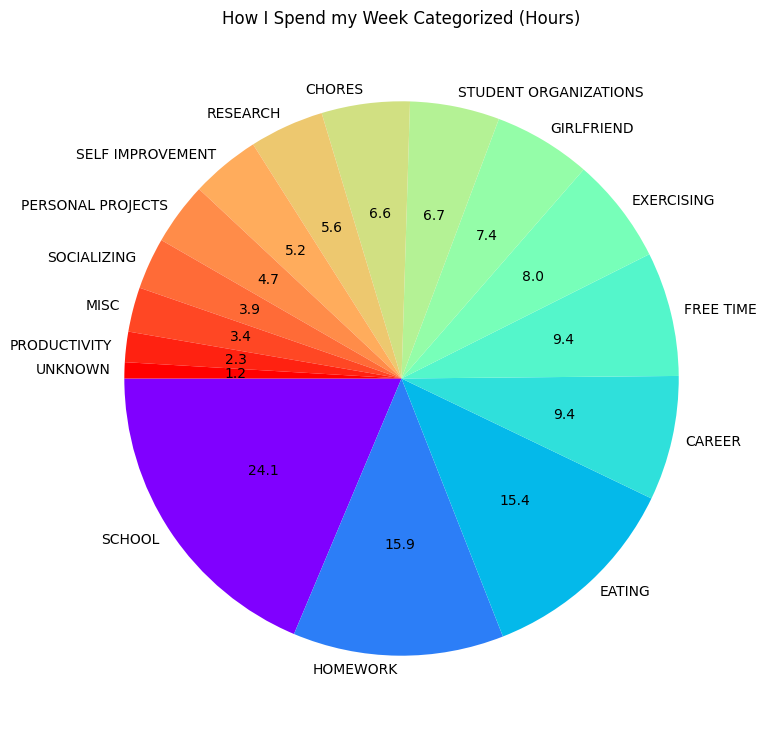

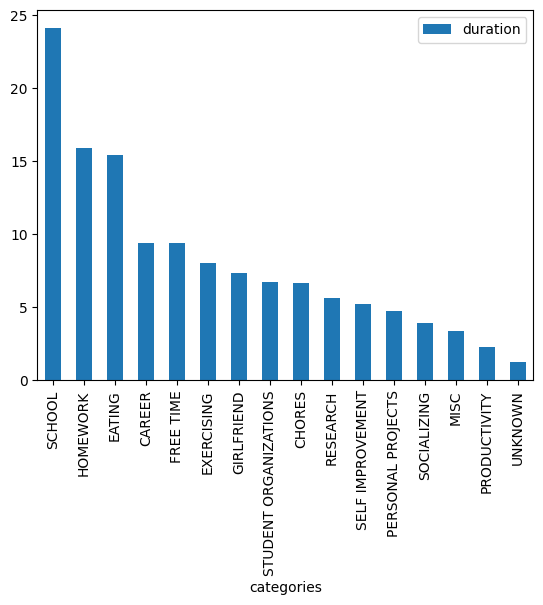

In [384]:
summation = sum_df_by_variable(events, "categories", "duration", "sum") 
summation /= 7
summation.sort_values(by="duration", ascending=False, inplace=True)
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = round((pct*total/10.0)) / 10
        return '{v:2}'.format(v=val) if pct > 0 else ''
    return my_format

values = summation['duration']

colors = plt.cm.rainbow(np.linspace(0, 1, len(summation)) ** (1/1.5))
title = "How I Spend my Week Categorized (Hours)"
# Plot the pie chart with a legend
ax = summation.plot.pie(y='duration', figsize=(9, 9), autopct=autopct_format(values), startangle=180, colors=colors, legend=False, title=title, labeldistance=1.05)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('')
savefig(title, type_="pie")
# plot a stacked bargraph 
summation.plot.bar(stacked=True)

In [291]:
summation

,duration
categories,
CAREER,11.107143
CHORES,2.821429
EATING,15.107143
EXERCISING,6.571429
FREE TIME,16.190476
GIRLFRIEND,4.428571
HOMEWORK,14.785714
MISC,2.750000
PERSONAL PROJECTS,10.785714
